In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import psycopg2 as pg2
from psycopg2 import extras

Analysis objectives:

1. **Most Common DTCs Analysis**
   - Identify and analyze the most frequent Diagnostic Trouble Codes (DTCs)
   - Determine patterns and trends in DTC occurrences

2. **DTC Distribution by Manufacturer**
   - Map how DTCs are distributed across different vehicle makes
   - Identify which manufacturers are most affected by specific DTCs

3. **Hardware Impact Analysis**
   - Identify which hardware part numbers are most affected by each DTC
   - Determine correlations between specific DTCs and hardware components


In [6]:
# Estabilish connection to PostgreSQL database
conn = pg2.connect(
    database='diagnostic_data_table',  # Database name
    user='postgres',                   # PostgreSQL user
    password='shakey-10'               # user password
    )              

In [3]:
# Create cursor with dict support
# DictCursor allows accessing columns by name instead of index
cur = conn.cursor(cursor_factory=pg2.extras.DictCursor)

In [4]:
# Excute SQL query that selects all columns (*) from table
cur.execute('SELECT * FROM zoho_google_data_cleaned_table')

In [ ]:
# Fetch all results from excuted query
# data_fecthed will contain a list of tuples, where each tuple is a table row
data_fecthed = cur.fetchall()

In [ ]:
# Create df with column names from databse
df_zoho_form_analysis = pd.DataFrame(
    data_fecthed,                                   # Data fectched from database
    columns=[description[0] for description in cur.description]  # Column names extraction
)  

In [47]:
# Print the info
df_zoho_form_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5352 entries, 0 to 5351
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   created_time                   5352 non-null   object
 1   h_number                       5352 non-null   object
 2   entry_type                     5352 non-null   object
 3   technician                     5337 non-null   object
 4   source                         5352 non-null   object
 5   year                           5352 non-null   object
 6   make                           5352 non-null   object
 7   model                          5351 non-null   object
 8   engine_size                    5204 non-null   object
 9   hdw_number                     4738 non-null   object
 10  part_number                    5085 non-null   object
 11  notes                          5352 non-null   object
 12  original_problems              5350 non-null   object
 13  ori

In [48]:
# Define the regex pattern to find the dtcs
dtcs_pattern = r'[PBCUpbcu]\d{3}[0-9A-Za-z]'

# List to store the dtcs found
fs1_dtcs_list = []

# Iterate under the column 'fs1-dtcs' to find the dtcs
for item in df_zoho_form_analysis['fs1_dtcs']:
    # Check if the data found is a string
    if isinstance(item, str):
        # Find all dtcs using the regex pattern
        fs1_dtcs_found = re.findall(dtcs_pattern, item, re.IGNORECASE)
        fs1_dtcs_list.extend(fs1_dtcs_found)

In [49]:
# Count the frequency of the dtcs
dtcs_counts = pd.Series(fs1_dtcs_list).value_counts()

In [50]:
# Create a dataframe from the result and name the columns
dtcs_quantity = pd.DataFrame({'DTCs': dtcs_counts.index, 'Quantity': dtcs_counts.values})

TOP DTCs ANALISYS

In [51]:
# Variable to save the top 15 dtcs as the DTC P0315 is not relevante or causes any problems.
top_dtcs = dtcs_quantity.head(16)

In [52]:
# Print the df
top_dtcs

,DTCs,Quantity
0,P0315,310
1,P0633,205
2,U0100,118
3,P0513,101
4,P0300,95
5,P0700,71
6,P1631,70
7,P2122,65
8,P2127,64
9,P160A,63


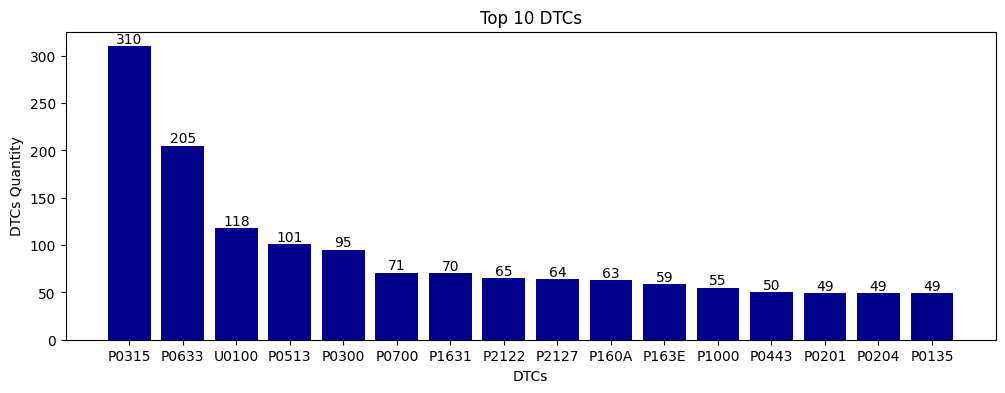

In [53]:
# Create the chart with the top 15 dtcs
plt.figure(figsize=(12, 4))
# Store in this variable to set the bar labels in the nethod = plt.bar_label 
bars = plt.bar(top_dtcs['DTCs'], top_dtcs['Quantity'], color='darkblue')
plt.xlabel('DTCs')
plt.ylabel('DTCs Quantity')
plt.title('Top 10 DTCs')
plt.bar_label(container=bars)
plt.show()

In [54]:
# Create a list from column 'DTCs'
top_dtcs_list = top_dtcs['DTCs'].tolist()

In [55]:
# Filter the main df containing the top 15 dtcs
df_filtered_top_dtcs = df_zoho_form_analysis[df_zoho_form_analysis['fs1_dtcs'].str.contains('|'.join(top_dtcs_list), na=False, case=False)]

TOP MAKES WHICH STORE THE TOP 15 DTCs

In [56]:
# Function to show a chart and a dataframe with all makes that stored the entered DTC 
def makes_top_dtcs_chart(dtc, df_filtered_top_dtcs):
    # Create a df with the entered DTC
    df_dtc_ = df_filtered_top_dtcs[df_filtered_top_dtcs['fs1_dtcs'].str.contains(dtc, na=False, case=False)]

    # Count the makes
    make_count_dtc = df_dtc_['make'].value_counts()

    # Create a df with the quantity/make
    make_quantity_dtc = pd.DataFrame({"Make": make_count_dtc.index, "Quantity": make_count_dtc.values})

    # Create a chart showing the result
    plt.figure(figsize=(8, 4))
    bars = plt.bar(make_quantity_dtc['Make'], make_quantity_dtc['Quantity'], color='green')
    plt.xlabel('Makes')
    plt.ylabel('Quantity')
    plt.title(f'Distribution of {dtc} Across Vehicle Makes')

    # Rotate the x labels to 90 degrees
    plt.xticks(rotation=30)

    plt.bar_label(container=bars)

    # Show the chart
    plt.show()

    # Return a df with the quantity/make and the main df filtered using the entered dtc 
    return {
        'make_quantity': make_quantity_dtc,
        'full_data': df_dtc_ 
    }

In [57]:
# Funtion to count and show the chart with the top 10 hdws with highest occurence / DTC
def count_show_chart_top_10_hdw_dtc(dtc, df_dtc_):
    # Count the hardware part number based on the determined dtc and filter the top 10
    count_hdws_dtc = df_dtc_['hdw_number'].value_counts().head(10)
    # Crate a df
    df_count_hdws_dtc = pd.DataFrame({'Hardware PN#': count_hdws_dtc.index, 'Quantity': count_hdws_dtc.values})

    # Chart to show the results
    plt.figure(figsize=(6, 4))
    bars = plt.barh(df_count_hdws_dtc['Hardware PN#'], df_count_hdws_dtc['Quantity'], color='darkorange')
    plt.ylabel("Hardware Part Number", fontdict={'weight': 'bold', 'color': 'black'})
    plt.xlabel("Quantity", fontdict={'weight': 'bold', 'color': 'black'})
    plt.title(f"Top 10 Hardware with Highest DTC {dtc} Occurrence", fontdict={'weight': 'bold', 'color': 'black'})
    plt.bar_label(bars)
    plt.show()

    # Return the created df showing the counting results 
    return df_count_hdws_dtc

In [58]:
# Function to call the charts and df with the analysis per dtc
def analyse_dtc(dtc, df_filtered_top_dtcs):

    # Print the dtc
    print(f'ANALISYS DTC - {dtc}')
    
    # Function to show a chart and a dataframe with all makes that stored the entered DTC
    results = makes_top_dtcs_chart(dtc, df_filtered_top_dtcs)
    
    # Df with makes and quantity from a given dtd
    make_quantity = results['make_quantity']
    # Main df filtered with a given dtc
    df_dtc = results['full_data']

    # Function to show the top 10 hdws with a given dtc
    hdw_analysis = count_show_chart_top_10_hdw_dtc(dtc, df_dtc)

    return make_quantity

The folloing analysis will be done after considering the top 16 dtcs stored with the FS1 modules:
- The makes which stored the dtcs
- The most common hardwares which stored the dtcs 

ANALISYS DTC - P0633


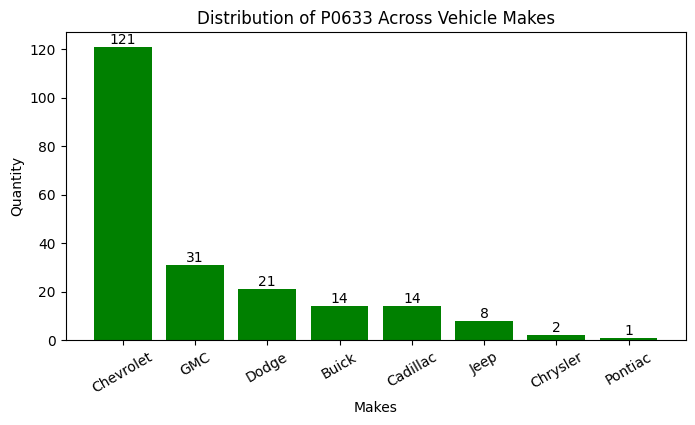

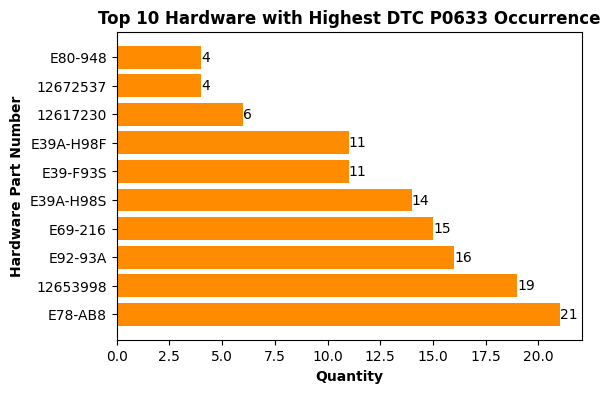

,Make,Quantity
0,Chevrolet,121
1,GMC,31
2,Dodge,21
3,Buick,14
4,Cadillac,14
5,Jeep,8
6,Chrysler,2
7,Pontiac,1


In [59]:
# Call the funtion to print the analysis with dtc P0633
analyse_dtc('P0633', df_filtered_top_dtcs)

ANALISYS DTC - U0100


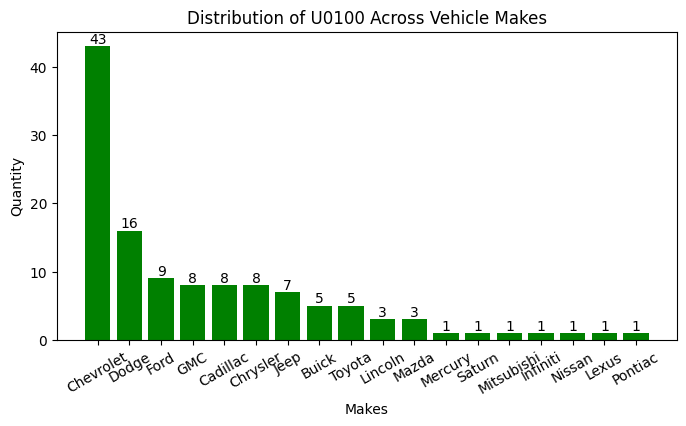

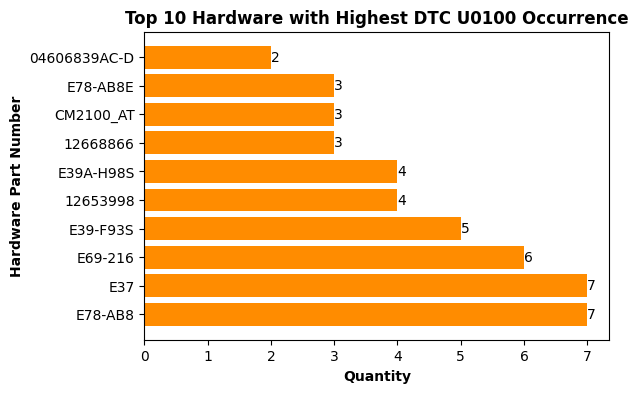

,Make,Quantity
0,Chevrolet,43
1,Dodge,16
2,Ford,9
3,GMC,8
4,Cadillac,8
5,Chrysler,8
6,Jeep,7
7,Buick,5
8,Toyota,5
9,Lincoln,3


In [60]:
# Call the funtion to print the analysis with dtc U0100
analyse_dtc("U0100", df_filtered_top_dtcs)

ANALISYS DTC - P0513


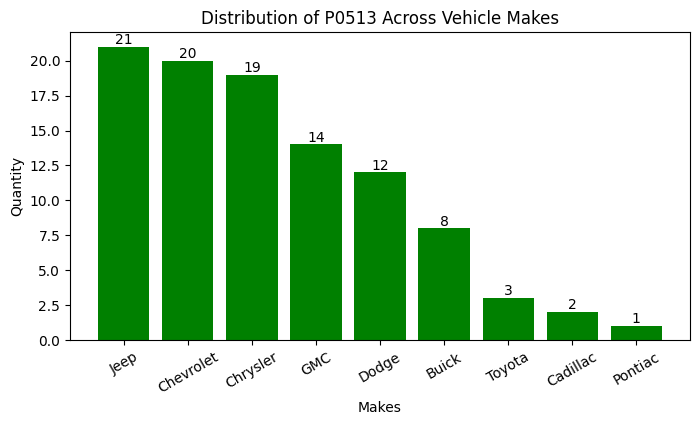

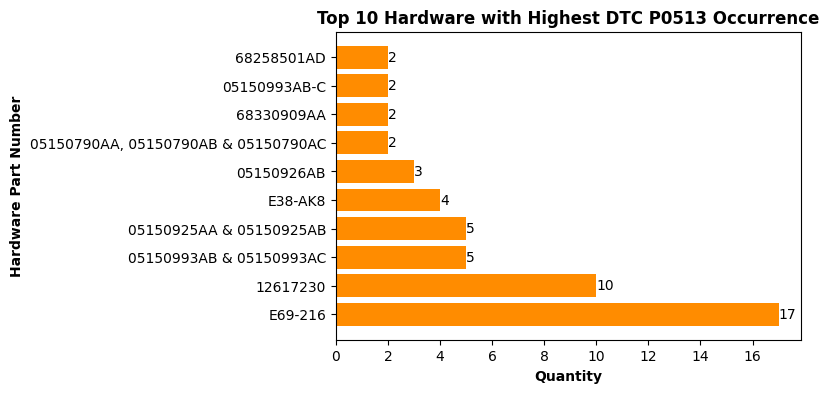

,Make,Quantity
0,Jeep,21
1,Chevrolet,20
2,Chrysler,19
3,GMC,14
4,Dodge,12
5,Buick,8
6,Toyota,3
7,Cadillac,2
8,Pontiac,1


In [61]:
# Call the funtion to print the analysis with dtc P0513
analyse_dtc('P0513', df_filtered_top_dtcs)

ANALISYS DTC - P0300


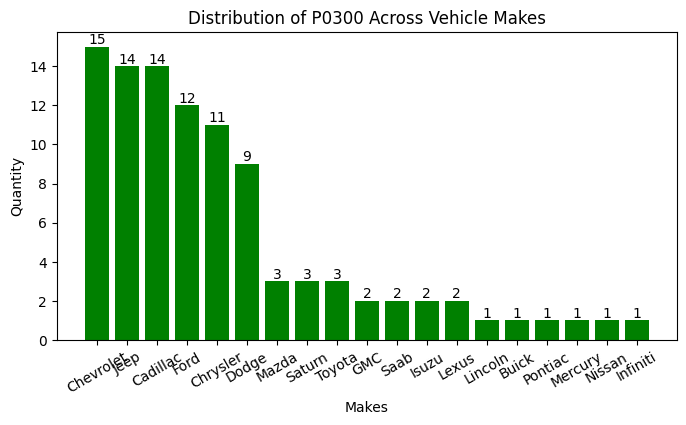

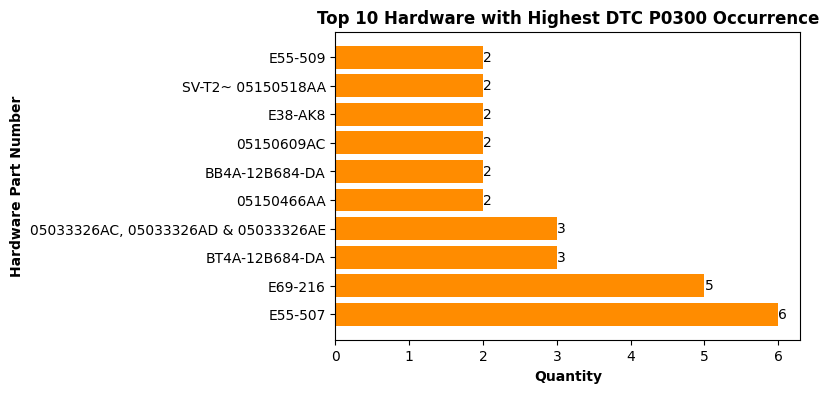

,Make,Quantity
0,Chevrolet,15
1,Jeep,14
2,Cadillac,14
3,Ford,12
4,Chrysler,11
5,Dodge,9
6,Mazda,3
7,Saturn,3
8,Toyota,3
9,GMC,2


In [62]:
# Call the funtion to print the analysis with dtc P0300
analyse_dtc('P0300', df_filtered_top_dtcs)

ANALISYS DTC - P0700


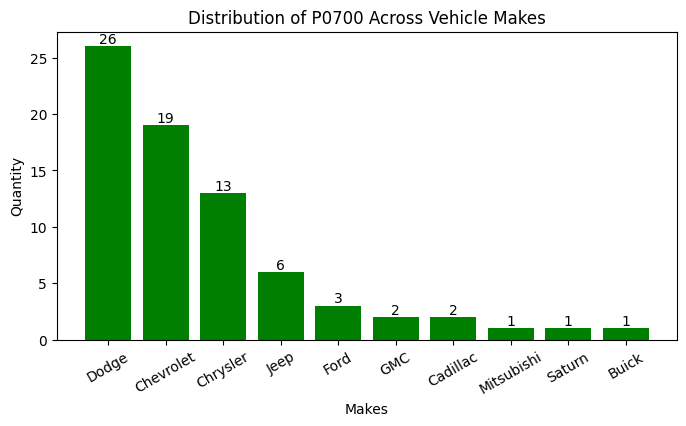

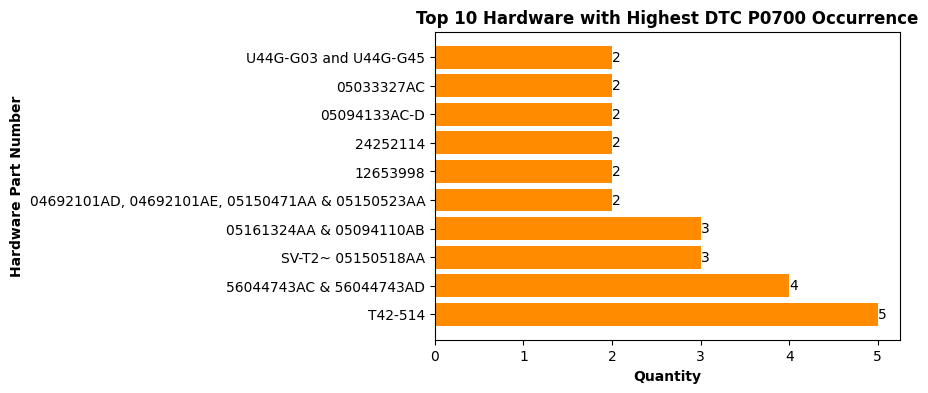

,Make,Quantity
0,Dodge,26
1,Chevrolet,19
2,Chrysler,13
3,Jeep,6
4,Ford,3
5,GMC,2
6,Cadillac,2
7,Mitsubishi,1
8,Saturn,1
9,Buick,1


In [63]:
# Call the funtion to print the analysis with dtc P0700
analyse_dtc('P0700', df_filtered_top_dtcs)

ANALISYS DTC - P1631


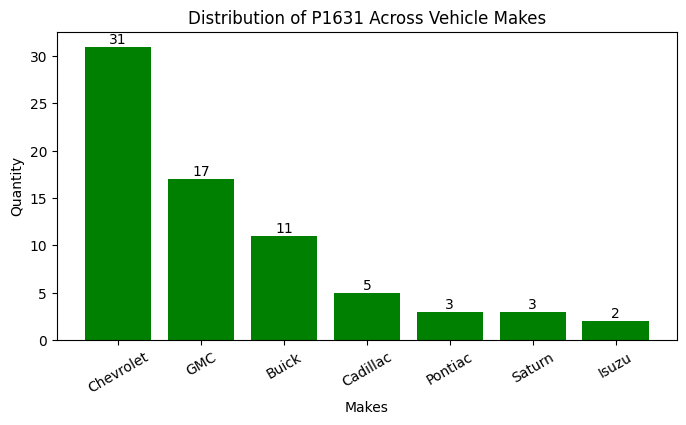

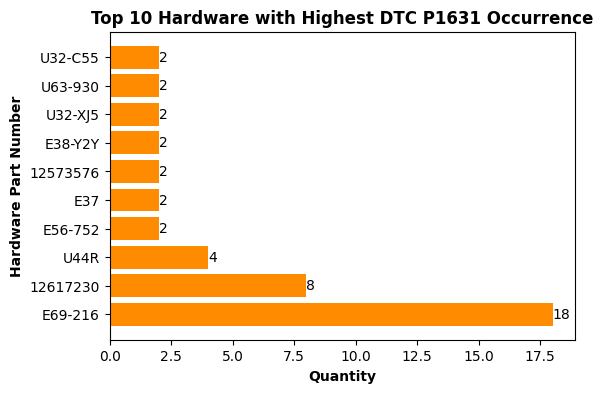

,Make,Quantity
0,Chevrolet,31
1,GMC,17
2,Buick,11
3,Cadillac,5
4,Pontiac,3
5,Saturn,3
6,Isuzu,2


In [64]:
# Call the funtion to print the analysis with dtc P1631
analyse_dtc("P1631", df_filtered_top_dtcs)

ANALISYS DTC - P2127


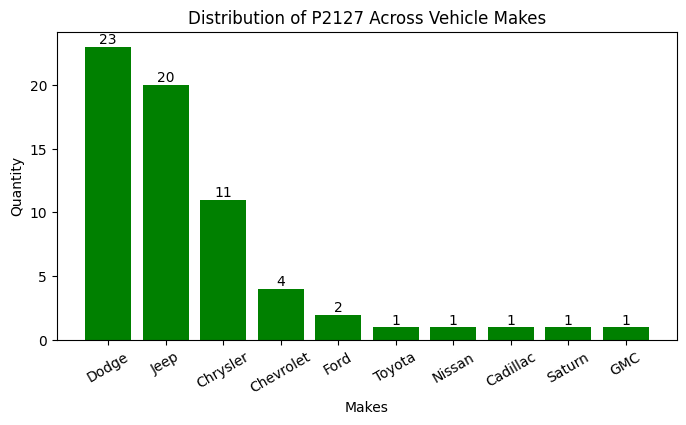

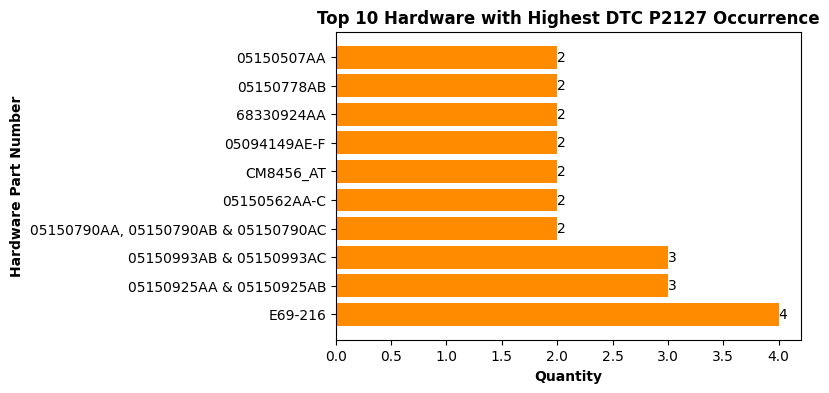

,Make,Quantity
0,Dodge,23
1,Jeep,20
2,Chrysler,11
3,Chevrolet,4
4,Ford,2
5,Toyota,1
6,Nissan,1
7,Cadillac,1
8,Saturn,1
9,GMC,1


In [65]:
# Call the funtion to print the analysis with dtc P2127
analyse_dtc("P2127", df_filtered_top_dtcs)

ANALISYS DTC - P2122


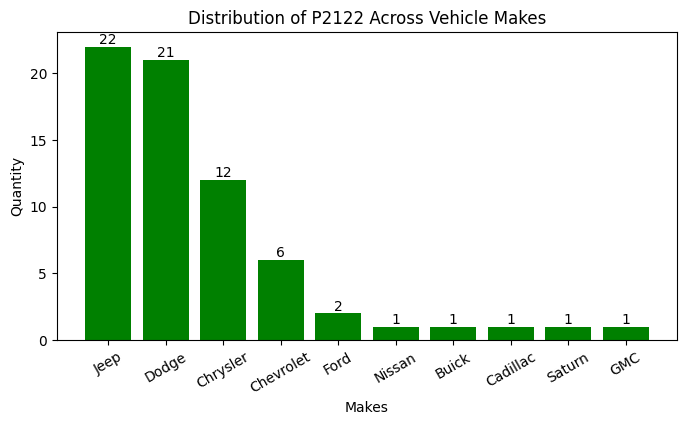

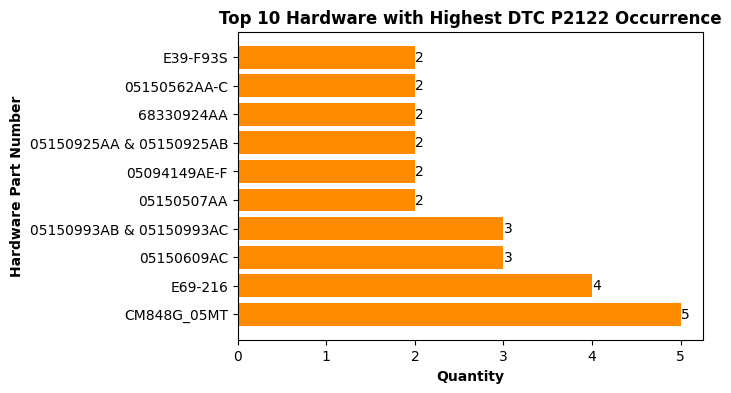

,Make,Quantity
0,Jeep,22
1,Dodge,21
2,Chrysler,12
3,Chevrolet,6
4,Ford,2
5,Nissan,1
6,Buick,1
7,Cadillac,1
8,Saturn,1
9,GMC,1


In [66]:
# Call the funtion to print the analysis with dtc P2122
analyse_dtc("P2122", df_filtered_top_dtcs)

ANALISYS DTC - P160A


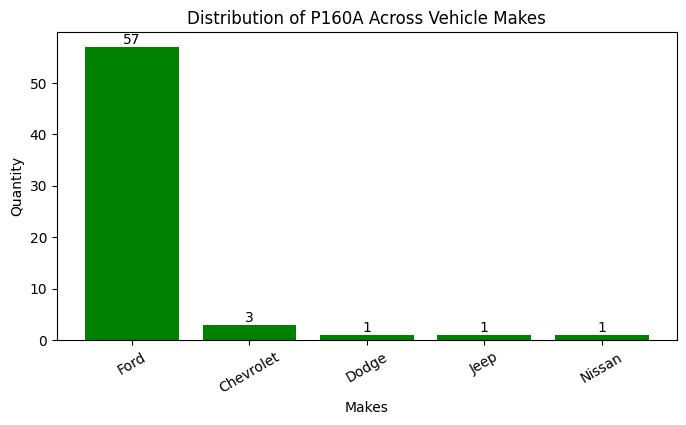

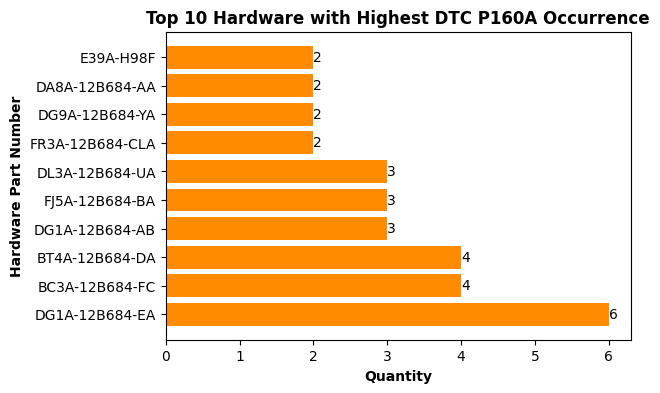

,Make,Quantity
0,Ford,57
1,Chevrolet,3
2,Dodge,1
3,Jeep,1
4,Nissan,1


In [67]:
# Call the funtion to print the analysis with dtc P160A
analyse_dtc("P160A", df_filtered_top_dtcs)

ANALISYS DTC - U0101


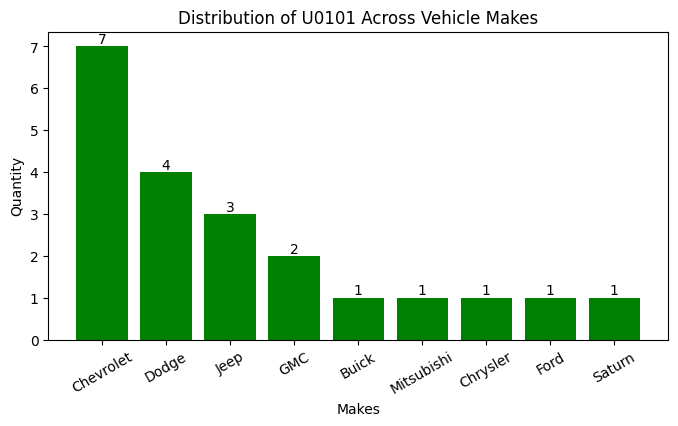

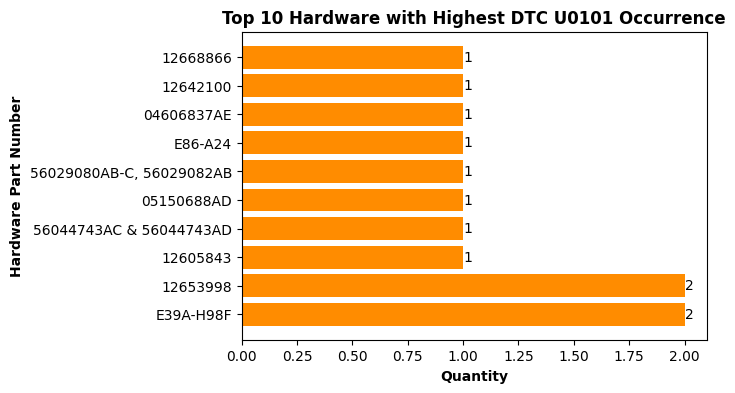

,Make,Quantity
0,Chevrolet,7
1,Dodge,4
2,Jeep,3
3,GMC,2
4,Buick,1
5,Mitsubishi,1
6,Chrysler,1
7,Ford,1
8,Saturn,1


In [68]:
# Call the funtion to print the analysis with dtc U0101
analyse_dtc("U0101", df_filtered_top_dtcs)

ANALISYS DTC - P0135


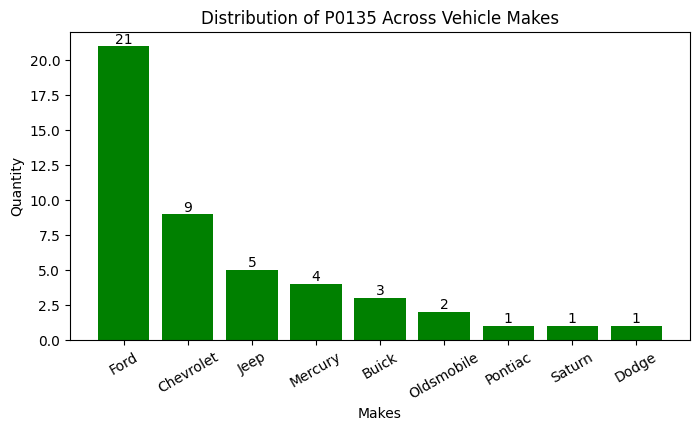

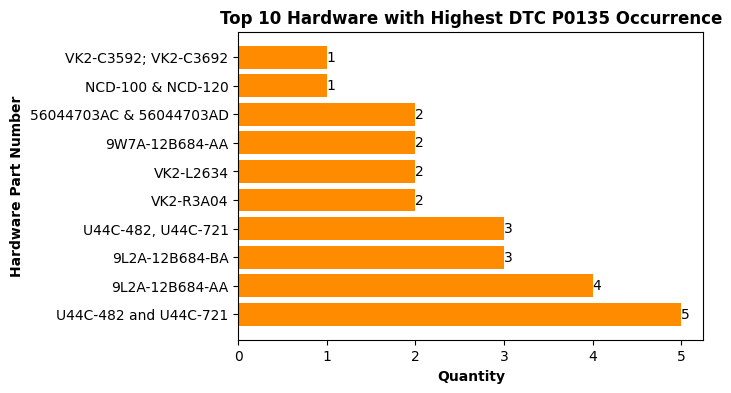

,Make,Quantity
0,Ford,21
1,Chevrolet,9
2,Jeep,5
3,Mercury,4
4,Buick,3
5,Oldsmobile,2
6,Pontiac,1
7,Saturn,1
8,Dodge,1


In [69]:
# Call the funtion to print the analysis with dtc P0135
analyse_dtc("P0135", df_filtered_top_dtcs)

ANALISYS DTC - P0204


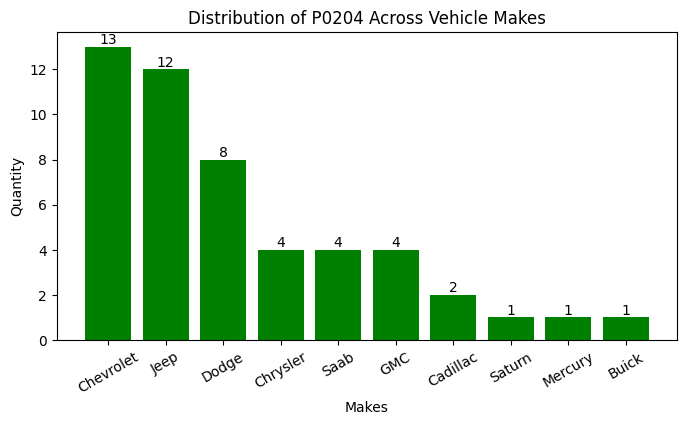

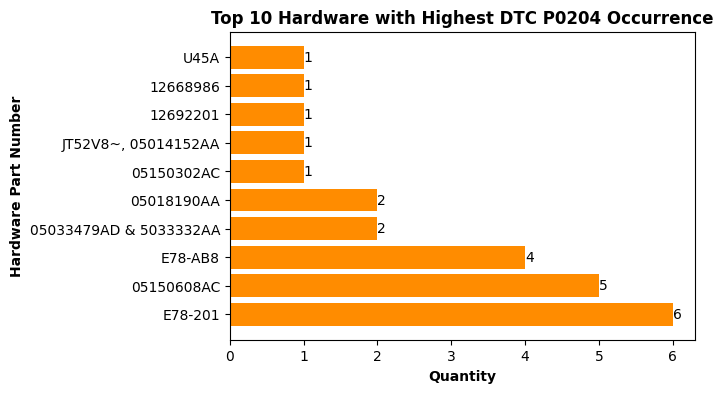

,Make,Quantity
0,Chevrolet,13
1,Jeep,12
2,Dodge,8
3,Chrysler,4
4,Saab,4
5,GMC,4
6,Cadillac,2
7,Saturn,1
8,Mercury,1
9,Buick,1


In [70]:
# Call the funtion to print the analysis with dtc P0204
analyse_dtc("P0204", df_filtered_top_dtcs)

ANALISYS DTC - P0443


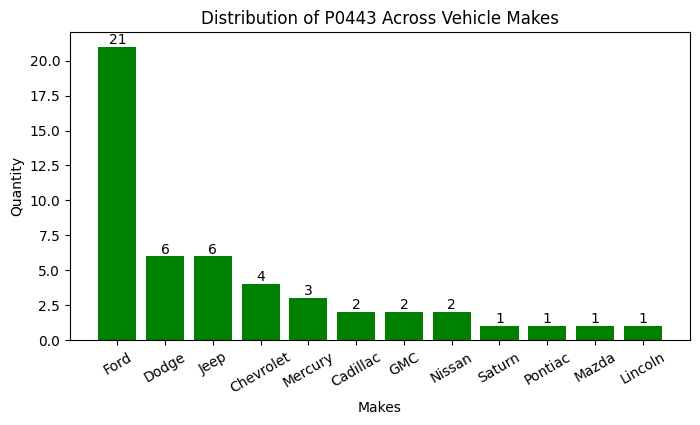

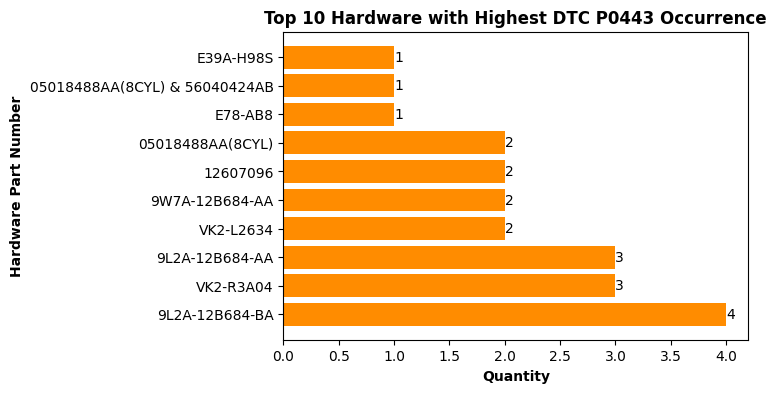

,Make,Quantity
0,Ford,21
1,Dodge,6
2,Jeep,6
3,Chevrolet,4
4,Mercury,3
5,Cadillac,2
6,GMC,2
7,Nissan,2
8,Saturn,1
9,Pontiac,1


In [71]:
# Call the funtion to print the analysis with dtc P0443
analyse_dtc("P0443", df_filtered_top_dtcs)